## Import das Bibliotecas e funções

In [1]:
import cv2

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from scipy.stats import randint as sp_randint

import os, json, itertools

In [2]:
from classes import Image

## Import dos dados

In [3]:
path = u'../data/placas/'
metadata_db = json.load(open('../data/metadata_db.json', 'r'))

In [4]:
def plot(imagem):
    plt.figure(figsize=(30,12))
    plt.imshow(imagem, cmap="gray")
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

In [5]:
np.random.seed(12321)

In [6]:
arq = os.listdir(path)
arq.sort()

num = 100
arq = [a for a in arq if a.startswith("track") and a.endswith(".png")]
arq = arq[:num]

In [7]:
ext = [a.replace('.png','') for a in arq]

grayscale = []

for a in arq:
    ppath = path + a
    imagem = cv2.imread(path+a, 0)
    grayscale.append(imagem)

## Testes de modificações

A seguir, aplicaremos algumas sequências de modificações nas imagens das placas, no intuito de descobrir a melhor sequência de operações para segmentar o conteúdo da placa.

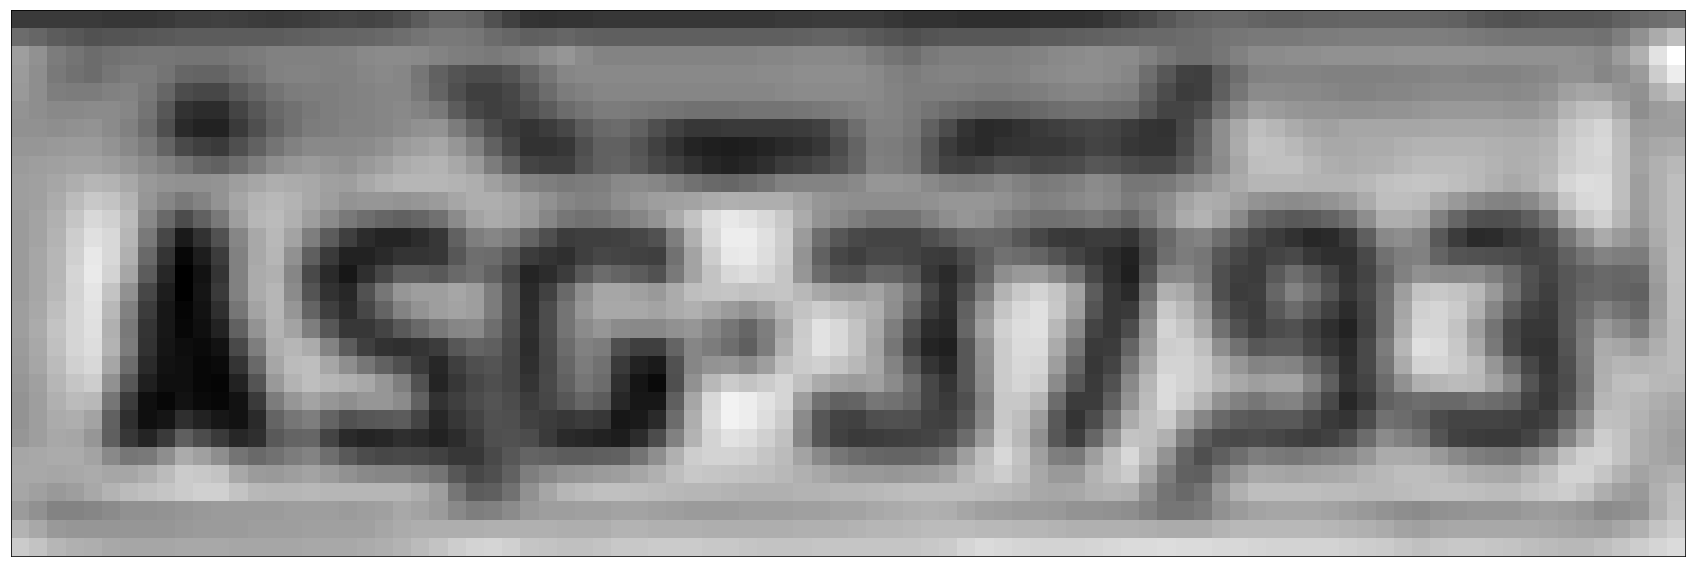

In [8]:
imagem = grayscale[90].copy()
hsv = cv2.cvtColor(imagem, cv2.COLOR_GRAY2BGR)
hsv = cv2.cvtColor(hsv, cv2.COLOR_BGR2HSV)
plot(imagem)

### Blurring

<BarContainer object of 64 artists>

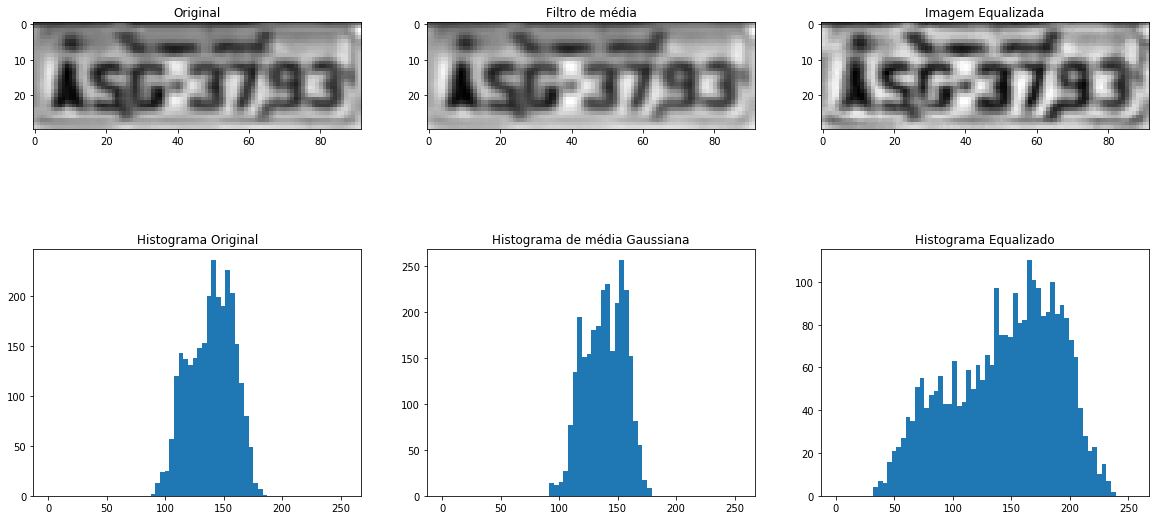

In [9]:
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
plt.title("Original")
plt.imshow(imagem, cmap="gray")

nbins = 64
h, bin_edges = np.histogram(imagem.ravel(), nbins, (0, 255))
w = 256./nbins

bin_centers = bin_edges[1:] - (w/2)
plt.subplot(2,3,4)
plt.title("Histograma Original")
plt.bar(bin_centers, h, width=w)

###################################################################

plt.subplot(2,3,2)
# teste_media = cv2.GaussianBlur(imagem.copy(), (5,5), 21, 21)
teste_media = cv2.bilateralFilter(imagem.copy(), 3, 75, 75)
plt.title("Filtro de média")
plt.imshow(teste_media, cmap="gray")

nbins = 64
h, bin_edges = np.histogram(teste_media.ravel(), nbins, (0, 255))
w = 256 / nbins

bin_centers = bin_edges[1:] - (w/2)
plt.subplot(2,3,5)
plt.title("Histograma de média Gaussiana")
plt.bar(bin_centers, h, width=w)

###################################################################

plt.subplot(2,3,3)
# teste_eql = cv2.equalizeHist(teste_media.copy(), (3,3))
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
teste_eql = clahe.apply(teste_media.copy())
plt.title("Imagem Equalizada")
plt.imshow(teste_eql.copy(), cmap="gray")

nbins = 64
h, bin_edges = np.histogram(teste_eql.ravel(), nbins, (0, 255))
w = 256 / nbins

bin_centers = bin_edges[1:] - (w/2)
plt.subplot(2,3,6)
plt.title("Histograma Equalizado")
plt.bar(bin_centers, h, width=w)

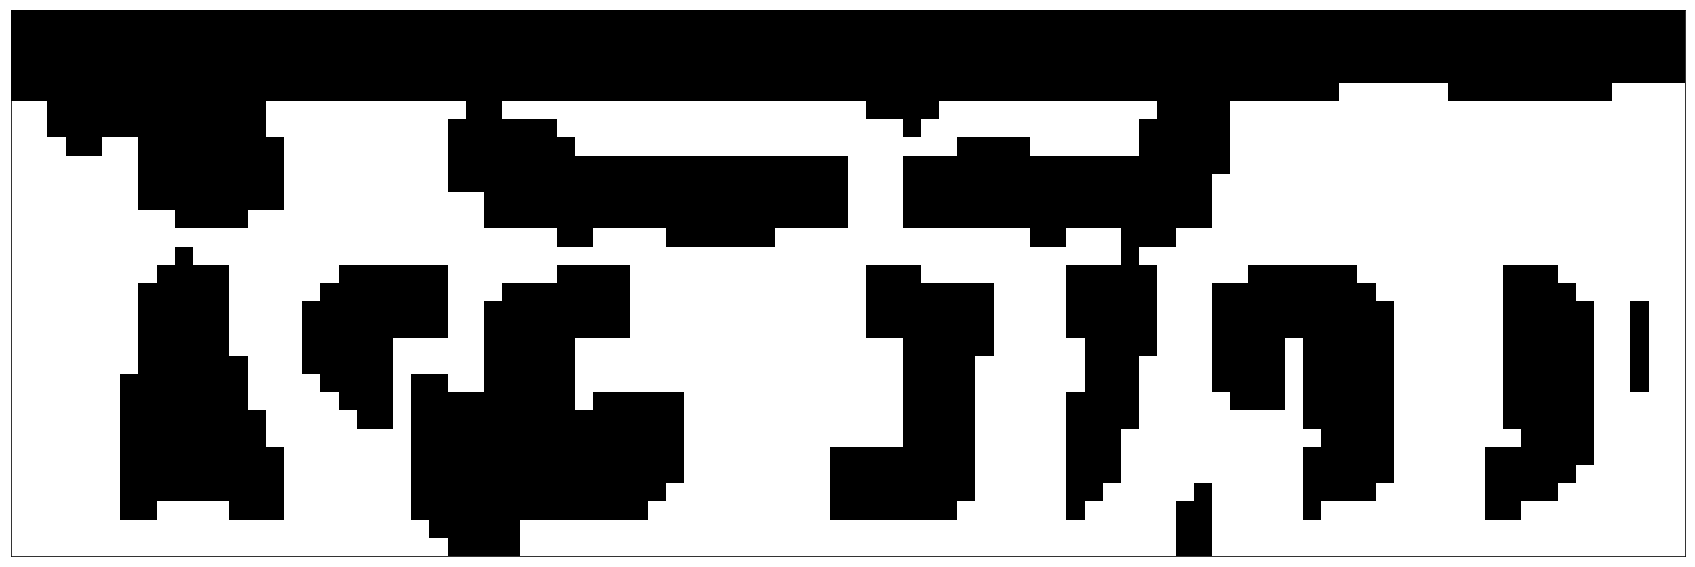

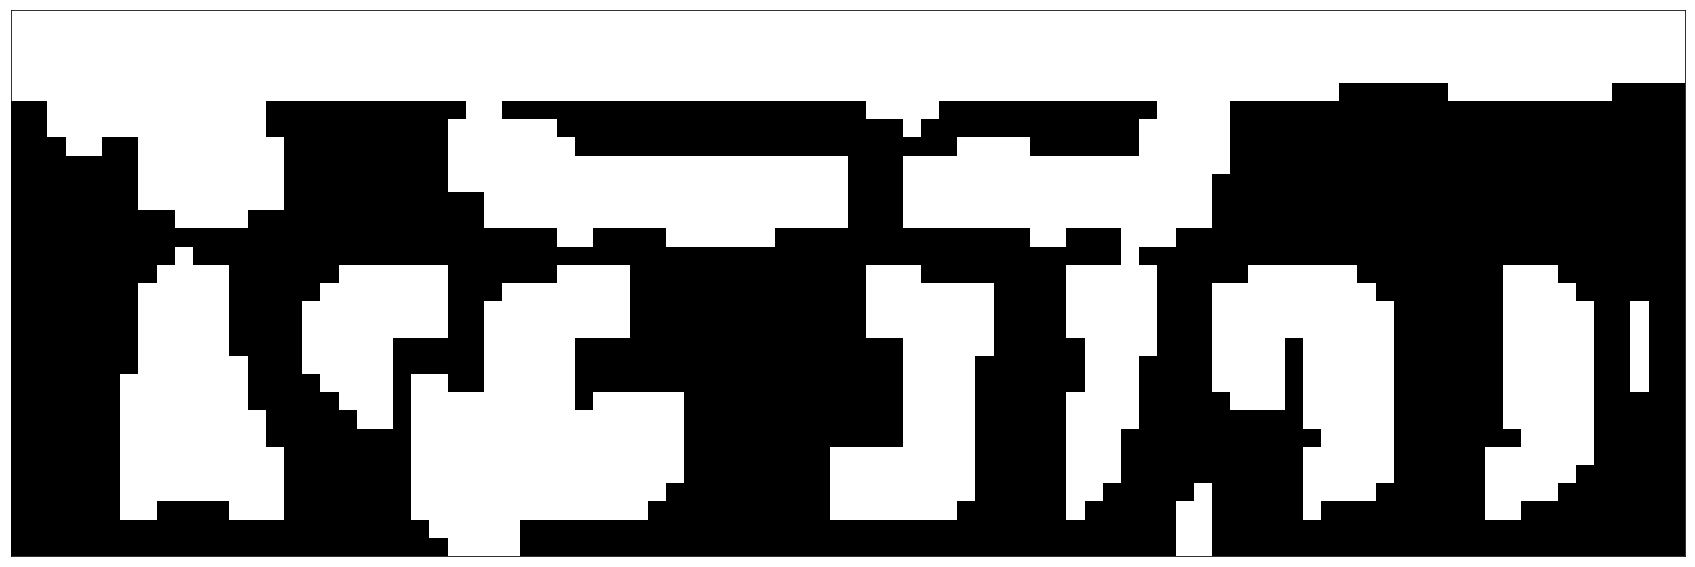

In [10]:
opening = cv2.morphologyEx(imagem.copy(), cv2.MORPH_CLOSE, (3,3), iterations=3)
_, binary_img = cv2.threshold(opening.copy(), 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plot(binary_img)
binary_inv = cv2.bitwise_not(binary_img.copy())
plot(binary_inv)

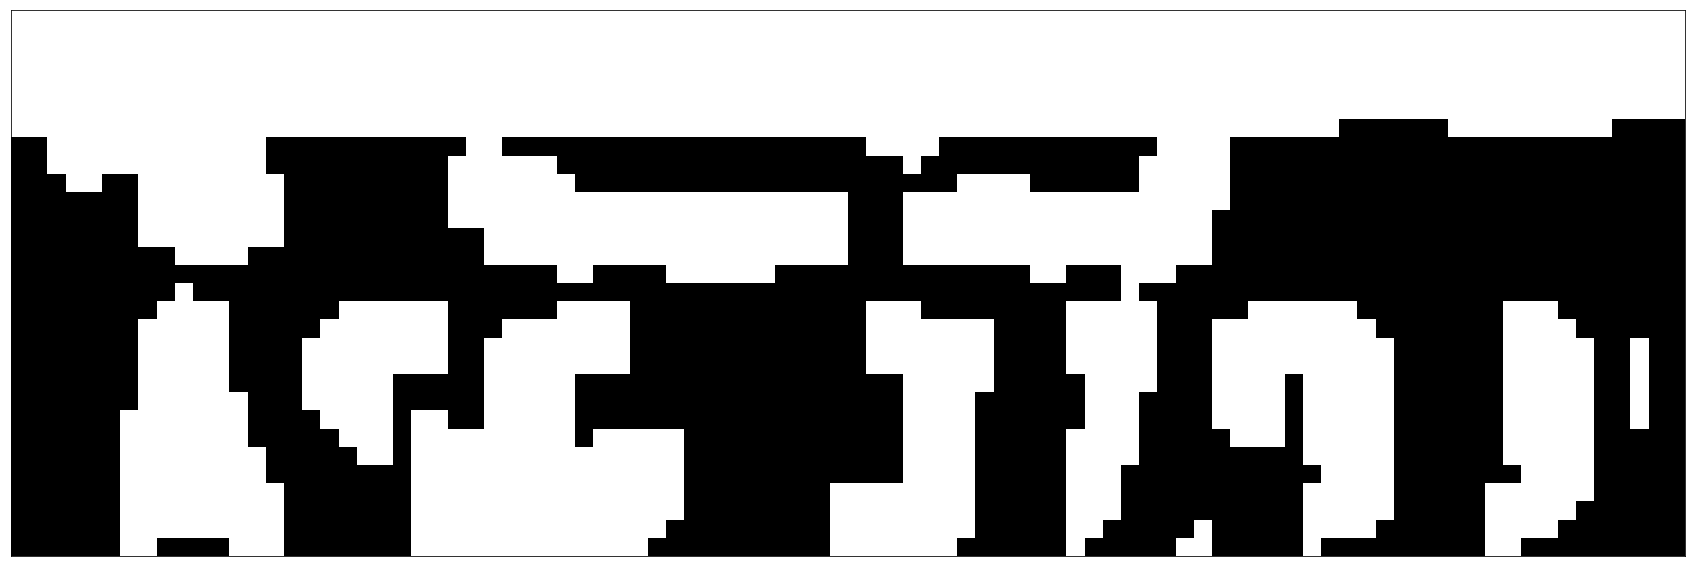

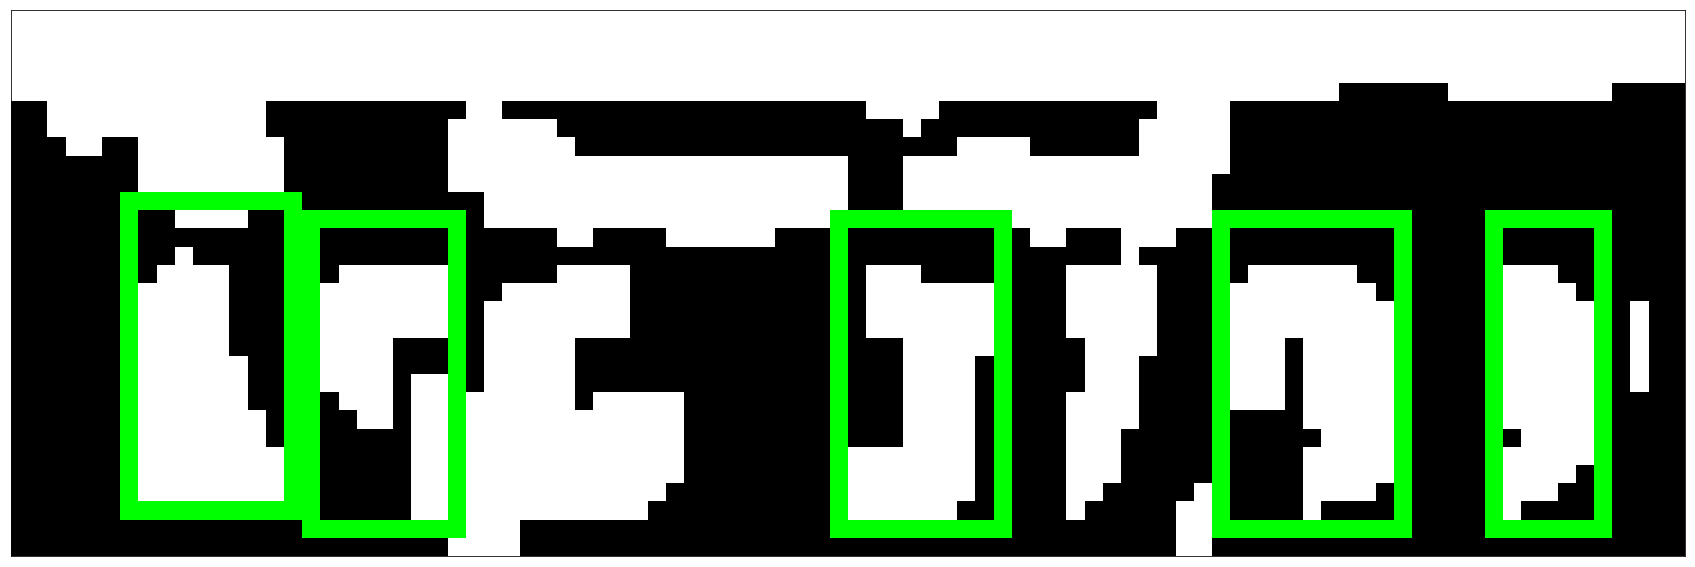

In [11]:
closed2 = cv2.morphologyEx(binary_inv.copy(), cv2.MORPH_OPEN, (5,5), iterations=2)
_, ctrs2, _ = cv2.findContours(closed2.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
plot(closed2)

here2 = binary_inv.copy()
here2 = cv2.cvtColor(here2, cv2.COLOR_GRAY2BGR)
for cnt in ctrs2:
    (x, y, w, h) = cv2.boundingRect(cnt)
    if (6 < h < 20 and 3 < w < 15 and 3 < x < 89):
        cv2.rectangle(here2, (x,y-5), (x+w,y+12), (0, 255, 0), 1)
plot(here2)

### Thresholding

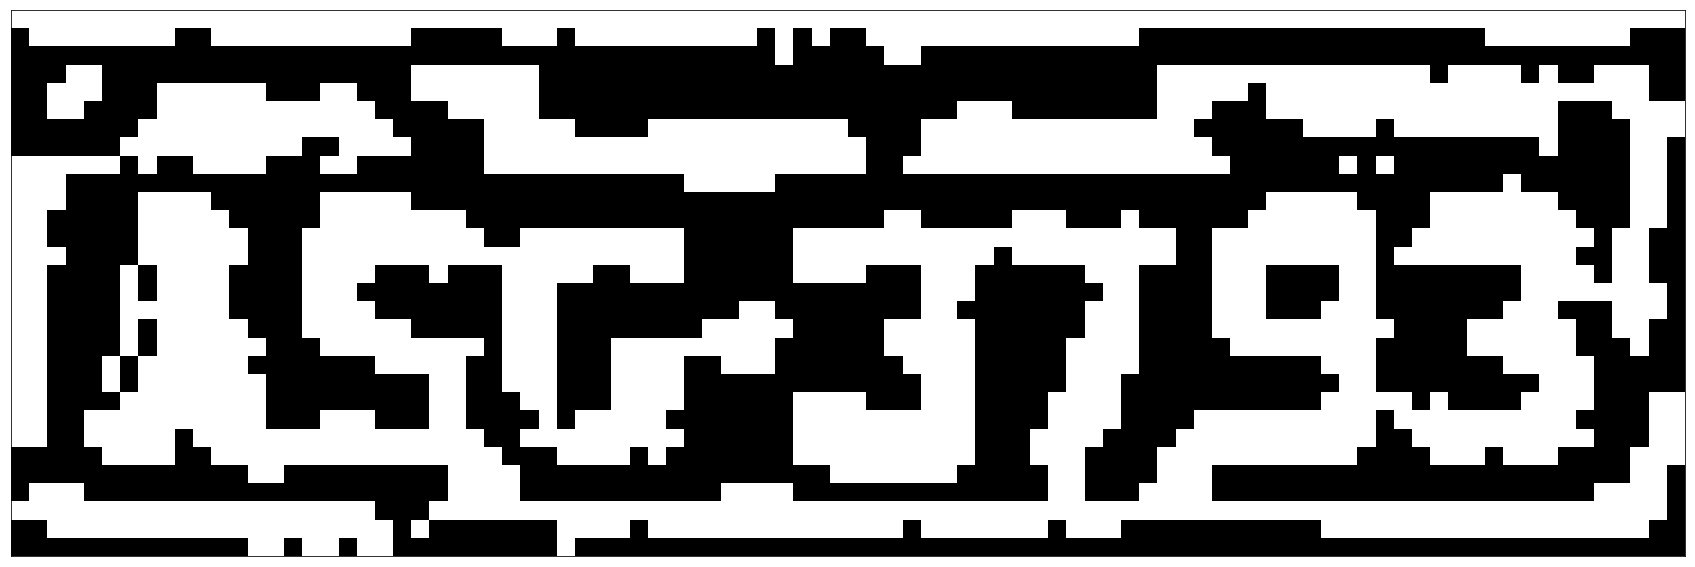

In [12]:
thr = cv2.adaptiveThreshold(teste_eql.copy(), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 5, 0)
plot(thr)

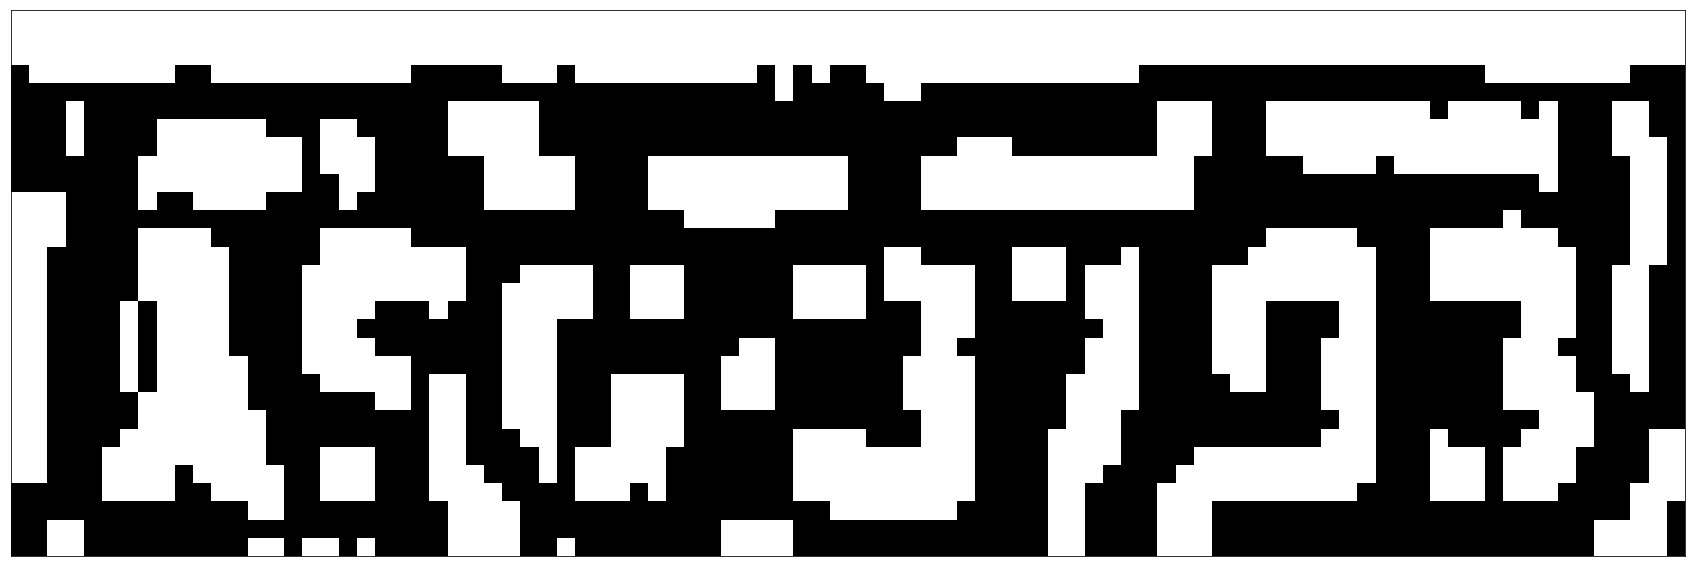

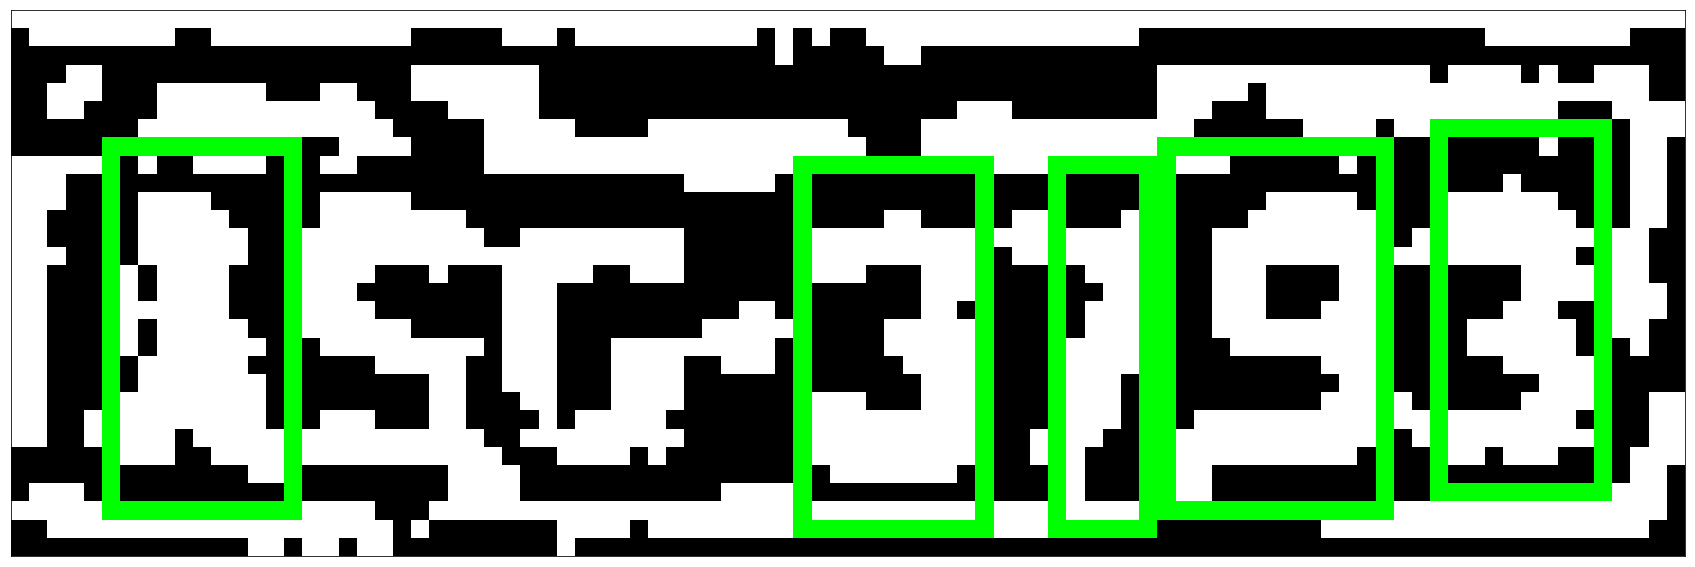

In [13]:
closed1 = cv2.morphologyEx(thr.copy(), cv2.MORPH_OPEN, (5,5), iterations=2)
_, ctrs1, _ = cv2.findContours(closed1.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plot(closed1)

here1 = thr.copy()
here1 = cv2.cvtColor(here1, cv2.COLOR_GRAY2BGR)
for cnt in ctrs1:
    (x, y, w, h) = cv2.boundingRect(cnt)
    if (12 < h < 20 and 3 < w < 15 and 3 < x < 89):
        cv2.rectangle(here1, (x,y-5), (x+w,y+15), (0, 255, 0), 1)
plot(here1)

## Analise das Pipelines

### Equalização Padrão

In [14]:
def pipeline(image, med_kernel=(7,7), sigX=21, sigY=21, blks=3, c=0, opker=(3,3), opiter=2):
    media = cv2.GaussianBlur(image.copy(), sigmaX=sigX, sigmaY=sigY, ksize=med_kernel)
    eql = cv2.equalizeHist(media.copy())
    threshold = cv2.adaptiveThreshold(eql.copy(), 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, C=c, blockSize=blks)
    closed = cv2.morphologyEx(threshold.copy(), cv2.MORPH_OPEN, kernel=opker, iterations=opiter)
    _, ctrs, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    n = 0
    for cnt in ctrs:
        (x, y, w, h) = cv2.boundingRect(cnt)
        if (12 < h < 20 and 3 < w < 15 and 3 < x < 89):
            n += 1
            
    return n

In [15]:
score = sum(pipeline(g) for g in grayscale)
score

403

In [30]:
def pipeline_summary(pipe, data, max_value):
    blur_values = [(i, i) for i in range(3, 25, 2)]
    block_values = [i for i in range(3, 25, 2)]
    opk_values = [(i, i) for i in range(3, 25, 2)]
    opit_values = [i for i in range(0, 15)]
    sigx_values = [i  for i in range(0, 31, 3)]
    sigy_values = [i  for i in range(0, 31, 3)]
    c_values = [i  for i in range(0, 16, 3)]
    
    iterate = [blur_values, block_values, opk_values,
              opit_values, sigx_values, sigy_values,
              c_values]
    
    best = (-1, (0, 0, 0, 0, 0, 0, 0))
    
    s = np.prod([len(i) for i in iterate])
    print('Total Combinations: {}'.format(s))
    
    for blur, block, opk, opit, sigx, sigy, c in itertools.product(*iterate):
        current_score = sum(pipe(g, med_kernel=blur, blks=block, opker=opk, opiter=opit, sigX=sigx, sigY=sigy, c=c) for g in data)
        if (current_score >  best[0]):
            best = (current_score, (blur, block, opk, opit, sigx, sigy, c))
            print(best[0])
        if (best[0] > 630):
            break
            
        s -= 1
        if (s % 1000 == 0): print(s)
    
    (blur_score, block_score, opk_score, opit_score, sigx_score, sigy_score, c_score) = best[1]
    print('Best Blur Kernel: {}\nBest Block Size: {}'.format(blur_score, block_score))
    print('Best Open Kernel: {}\nBest Open Iteration: {}'.format(opk_score, opit_score))
    print('Best Sigma X: {}\nBest Sigma Y: {}'.format(sigx_score, sigy_score))
    print('Best C: {}'.format(c_score))
    print('Final Score: {}%%'.format(best[0]/max_value))
    
    return best[1]

In [31]:
pipeline_summary(pipeline, grayscale, 700.0)

Total Combinations: 14494590
172
383
537
550
554
555
14494000
571
588
594
621
636
Best Blur Kernel: (3, 3)
Best Block Size: 3
Best Open Kernel: (3, 3)
Best Open Iteration: 2
Best Sigma X: 0
Best Sigma Y: 3
Best C: 3
Final Score: 0.9085714285714286%%


((3, 3), 3, (3, 3), 2, 0, 3, 3)

In [ ]:
blur_kernel = [sum(pipeline(g, med_kernel=(i, i)) for g in grayscale)/700.0 for i in range(3, 100, 2)]
plt.figure(figsize=(30,12))
plt.plot(blur_kernel)
np.argmax(blur_kernel)

In [ ]:
block_size = [sum(pipeline(g, blks=i)/700.0 for g in grayscale) for i in range(3, 100, 2)]
plt.figure(figsize=(30,12))
plt.plot(block_size)
np.argmax(block_size)

In [ ]:
open_kernel = [sum(pipeline(g, opker=(i, i))/700.0 for g in grayscale) for i in range(3, 100, 2)]
plt.figure(figsize=(30,12))
plt.plot(open_kernel)
np.argmax(open_kernel)

In [ ]:
open_iter = [sum(pipeline(g, opiter=i)/700.0 for g in grayscale) for i in range(3, 16, 2)]
plt.figure(figsize=(30,12))
plt.plot(open_iter)
np.argmax(open_iter)

In [ ]:
sigmax = [sum(pipeline(g, sigX=i)/700.0 for g in grayscale) for i in range(3, 52, 2)]
plt.figure(figsize=(30,12))
plt.plot(sigmax)
np.argmax(sigmax)

In [ ]:
sigmay = [sum(pipeline(g, sigY=i)/700.0 for g in grayscale) for i in range(3, 52, 2)]
plt.figure(figsize=(30,12))
plt.plot(sigmay)
np.argmax(sigmay)

In [ ]:
cs = [sum(pipeline(g, c=i)/700.0 for g in grayscale) for i in range(0, 52, 1)]
plt.figure(figsize=(30,12))
plt.plot(cs)
np.argmax(cs)

### Equalização com limite luminosidade

In [32]:
def pipeline_clahe(image, med_kernel=(7,7), sigX=21, sigY=21, blks=3, c=0, opker=(3,3), opiter=2):
    media = cv2.GaussianBlur(image.copy(), sigmaX=sigX, sigmaY=sigY, ksize=med_kernel)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(15,15))
    eql = clahe.apply(media.copy())
    threshold = cv2.adaptiveThreshold(eql.copy(), 255, 
                                cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, C=c, blockSize=blks)
    closed = cv2.morphologyEx(threshold.copy(), cv2.MORPH_OPEN, kernel=opker, iterations=opiter)
    _, ctrs, _ = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    n = 0
    for cnt in ctrs:
        (x, y, w, h) = cv2.boundingRect(cnt)
        if (12 < h < 20 and 3 < w < 15 and 3 < x < 89):
            n += 1
            
    return n

In [33]:
score = sum(pipeline_clahe(g) for g in grayscale)
score

505

In [34]:
pipeline_summary(pipeline_clahe, grayscale, 700.0)

Total Combinations: 14494590
125
393
525
541
544
14494000
606
612
636
Best Blur Kernel: (3, 3)
Best Block Size: 3
Best Open Kernel: (3, 3)
Best Open Iteration: 1
Best Sigma X: 0
Best Sigma Y: 6
Best C: 3
Final Score: 0.9085714285714286%%


((3, 3), 3, (3, 3), 1, 0, 6, 3)